In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

In [2]:
import matplotlib.pyplot as plt

In [332]:
from functools import *
import json

In [404]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [406]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

In [4]:
dat = pd.read_csv("/Users/stevetran/Downloads/VinIDRecruitChallenge/VinIDRecruitChallenge_MLTrack_DataSet.csv")

In [5]:
dat["date"] = pd.to_datetime(dat["date"])

In [6]:
dat["day_of_week"] = dat["date"].map(lambda d: d.day_name())

In [7]:
dat.sort_values(by=["date"],inplace=True)

In [8]:
df_flatten = pd.read_csv("flatten.csv",date_parser=["date"])

In [9]:
df_flatten["date"] = pd.to_datetime(df_flatten["date"])

In [10]:
df_flatten.sort_values(by=["date"],ascending=True,inplace=True)

In [11]:
df_flatten["salesquantity"] = df_flatten["salesquantity"].map(np.ceil).astype('uint')

# Problem:
Predict which customers make at least 1 purchase in a given month using features generated from the 2 previous months

We can rephrase this problem into ML: The probability of repeatable buyers in next month.
We limit the problem that are looked back at least two months data

# Dataset

We have dataset from Feb to July, so we split the dataset
- Training: From (Feb, March, April), (March, April, May)
- Testing: (April,May,(June,July))

## Metric
We evaluate the model using F1 score, False Alarm score

In [12]:
train_dat = df_flatten[df_flatten["date"]<="2018-06-01"].copy(deep=True)
test_dat = df_flatten[df_flatten["date"]>"2018-06-01"].copy(deep=True)

In [13]:
len(train_dat["csn"].unique())

18032

In [14]:
len(test_dat["csn"].unique())

9002

In [419]:
def visualize_roc_kfold(classifier, X, y, cv):
    from sklearn.metrics import plot_roc_curve, auc, roc_auc_score
    from numpy import interp
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

In [227]:
def calculate_prior_items(data):
    last_purchases_user_items = {}
    items_priors_day = np.zeros(len(data),dtype="uint")
    for user_id in data["csn"].unique():
        last_purchases_user_items[user_id] = {}
        
    idx = 0
    for _, row in data.sort_values(by=["date"],ascending=True).iterrows():
        user_id = row["csn"]
        item_id = row["article"]
        timestamp = row["date"]
        delta = 0
        if item_id in last_purchases_user_items[user_id]:        
            last_time_purchase = last_purchases_user_items[user_id][item_id]
            delta = (timestamp - last_time_purchase).days
        last_purchases_user_items[user_id][item_id] = timestamp
        items_priors_day[idx] = delta
        idx+=1
    return items_priors_day

In [228]:
def calculate_dow_features(data):
    features = {}
    for name, group in data.groupby(["csn"]):
        dow_cnt = np.zeros(7,dtype=np.uint)
        for idx in group["date"].map(lambda d: d.dayofweek).unique():
            dow_cnt[idx] += 1        
        
        features[name] = dow_cnt
    return pd.DataFrame(features).T

In [229]:
def calculate_reorder(data):
    features = {}
    for name, group in data.groupby(["csn"]):
        features[name] = {}
        sample = group.copy(deep=True)
        sample["prior_items"] = calculate_prior_items(sample)

        reorder_products = sample.query("prior_items>0")["article"].nunique()
        total_products = sample["article"].nunique()
        reorder_orders = sample.groupby(["date"])["prior_items"].sum()
        
        ratio = 1.0 * reorder_products / total_products
        new_products = total_products - reorder_products
        
        features[name]["reorder_rate"] = ratio
        features[name]["new_product"] = int(new_products)

        features[name]["orders_has_new_products"] = reorder_orders[reorder_orders==0].count()
        for item in sample[sample["prior_items"]>0]["salesquantity"].agg(["std","median","min","max"]).reset_index().values:
                k = "salesquantity_reorder_%s"%(item[0])
                features[name][k] = item[1]
        for item in sample[sample["prior_items"]>0]["prior_items"].agg(["std","median","min","max"]).reset_index().values:
                k = "prior_items_days_%s"%(item[0])
                features[name][k] = item[1]        
    feats_df = pd.DataFrame(features).T
    feats_df["new_product"] = feats_df["new_product"].astype('uint')
    return feats_df

In [230]:
def calculate_active(data):
    features = {}
    new_data = data.copy(deep=True)
    new_data["month"] = new_data["date"].map(lambda d: d.month)
    return new_data.groupby(["csn"])["month"].nunique()
        

In [231]:
agg_func = ['min','max','sum','std','mean','median']
def compute_last_n_days(data,time_max,lookbacks=[1,2,3,7,14,21,30]):    
    features = {}
    for user_id, group in data.groupby(["csn"]):
        features[user_id] = {}
        tmp = {}
        
#         s1 = time.time()
        group = group.set_index(["date"])
#         s2 = time.time()
        
        for lookback in lookbacks:
            timestamp = time_max - timedelta(days=lookback)
            stats = {
                    "unique_products":0,
                    "total_quantity": 0,
                    "sales": 0
            }
            if timestamp in group.index:
                df_filter = group.loc[timestamp:timestamp]
                stats = {
                    "unique_products":df_filter["article"].nunique(),
                    "total_quantity": df_filter["salesquantity"].sum(),
                    "sales": df_filter["price"].sum()
                }
            for k, v in stats.items():
                k_features = "last_{days}_days_{metric}".format(days=lookback,metric=k)
                tmp[k_features] = int(v)
        
#         s3 = time.time()
#         print("Delta: ",(s2-s1),(s3-s2))
        group = group.reset_index()
        
        last_purchase_date = group["date"].max()
        delta_days = (time_max - last_purchase_date).days
        tmp["user_last_purchase_date"] = int(delta_days)
        
        tmp["avg_products_in_cart"] = group.groupby(["date"])["article"].count().mean()
        tmp["number_of_products"] = group.groupby(["date"])["article"].count().sum()
        
        stats = group.groupby(["date"]).agg(
        {
            "salesquantity":agg_func,
            "price":agg_func
        }).mean().reset_index().values
        
        for i in range(len(stats)):
            k1, k2, val = stats[i]
            k = k1+"_"+k2
            tmp[k] = val       
            
        features[user_id] = tmp
            
    return pd.DataFrame(features).T

In [232]:
def get_features_from_df(df_train,df_test,df_last_time,time_max):
    df_last_purchase = compute_last_n_days(df_train,time_max=time_max)
    df_dow_features = calculate_dow_features(df_train)
    df_reorder_features = calculate_reorder(df_train)
    df_last_active = calculate_active(df_last_time)

    df_features = df_last_purchase.join(df_reorder_features)\
        .join(df_dow_features)\
        .join(df_last_active)\
        .copy(deep=True)\
        .reset_index()\
        .rename({"index":"csn"},axis=1)

    test_csn = set(df_test["csn"].unique())
    df_features["label"] = df_features["csn"].map(lambda d: 1 if d in test_csn else 0)
    print(df_features["label"].value_counts())
    return df_features

## Creating User Features

In [233]:
train_times = ["2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01","2018-07-01"]

In [237]:
X_total = []
for i in range(len(train_times)-2):
    print("Processing ", train_times[i])
    start = train_times[i]
    end = train_times[i+1]
    upper = train_times[i+2]
    print(start,end,upper)
    
    d = set(df_flatten[(df_flatten["date"]>=start)&(df_flatten["date"]<end)]["csn"].unique())
    e = set(df_flatten[(df_flatten["date"]>=end)&(df_flatten["date"]<upper)]["csn"].unique())
    print(len(d),len(e),len(e.intersection(d)))
    train_df = df_flatten[(df_flatten["date"]>=start)&(df_flatten["date"]<end)]
    test_df = df_flatten[(df_flatten["date"]>=end)&(df_flatten["date"]<upper)]
    last_seen_df = df_flatten[df_flatten["date"]<end]
    
    X_total.append(get_features_from_df(train_df,test_df,last_seen_df,time_max=datetime.strptime(end,"%Y-%m-%d")))

Processing  2018-02-01
2018-02-01 2018-03-01 2018-04-01
9978 8940 5634
1    5634
0    4344
Name: label, dtype: int64
Processing  2018-03-01
2018-03-01 2018-04-01 2018-05-01
8940 9078 5497
1    5497
0    3443
Name: label, dtype: int64
Processing  2018-04-01
2018-04-01 2018-05-01 2018-06-01
9078 9106 5471
1    5471
0    3607
Name: label, dtype: int64
Processing  2018-05-01
2018-05-01 2018-06-01 2018-07-01
9106 9210 5441
1    5441
0    3665
Name: label, dtype: int64


In [238]:
df_features = pd.concat(X_total)

In [256]:
df_for_train = pd.concat(X_total[:3])
df_for_test = X_total[-1].copy(deep=True)

In [240]:
# df_features.to_csv("df_features.csv",index=None)

In [265]:
df_for_train.fillna(-1,inplace=True)
df_for_test.fillna(-1,inplace=True)

In [268]:
X = df_for_train.drop(["csn","label"],axis=1).values
y = df_for_train["label"].values

In [329]:
X_test = df_for_test.drop(["csn","label"],axis=1).values
y_test = df_for_test["label"].values

## Logistic Regression

In [408]:
# Normalize Features to [0,1] scale
scaler = MinMaxScaler().fit(X)

In [409]:
X_transform = scaler.transform(X)

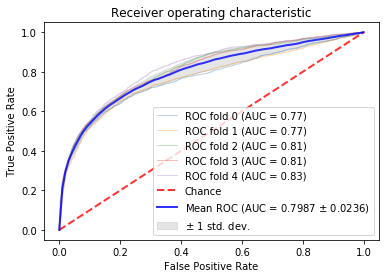

In [324]:
visualize_roc_kfold(LogisticRegression(max_iter=10000),X_transform,y,cv=KFold(n_splits=5))

## Features interaction

In [410]:
poly = PolynomialFeatures(degree=2)

In [416]:
X_transform_degree = scaler.fit_transform(poly.fit_transform(X))

In [421]:
# visualize_roc_kfold(LogisticRegression(max_iter=10000),X_transform_degree,y,cv=KFold(n_splits=5))

In [420]:
cross_val_score(LogisticRegression(max_iter=10000),X_transform_degree,y,cv=KFold(n_splits=5))

array([0.70821429, 0.71584211, 0.72709412, 0.72923736, 0.7579925 ])

## LightGBM

In [325]:
import lightgbm

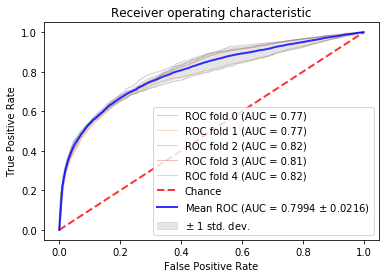

In [328]:
visualize_roc_kfold(lightgbm.LGBMClassifier(
                n_estimators=400,
                subsample=0.9,                                                          
                learning_rate=0.01),X,y,cv=KFold(n_splits=5))

In [343]:
model = lightgbm.LGBMClassifier(
                n_estimators=400,
                subsample=0.85,                                                          
                learning_rate=0.01).fit(X,y)

In [344]:
y_pred = model.predict_proba(X_test)
print(roc_auc_score(y_true=y_test,y_score=y_pred[:,1]))

0.8212818243978002


In [362]:
df_important = pd.DataFrame(list(zip(df_features.drop(["csn","label"],axis=1).columns,model.feature_importances_)),columns=["feature","coff"])\
    .set_index(["feature"])\
    .sort_values(by="coff",ascending=False)

In [363]:
df_important["coff_norm"] = df_important["coff"]/df_important["coff"].max()

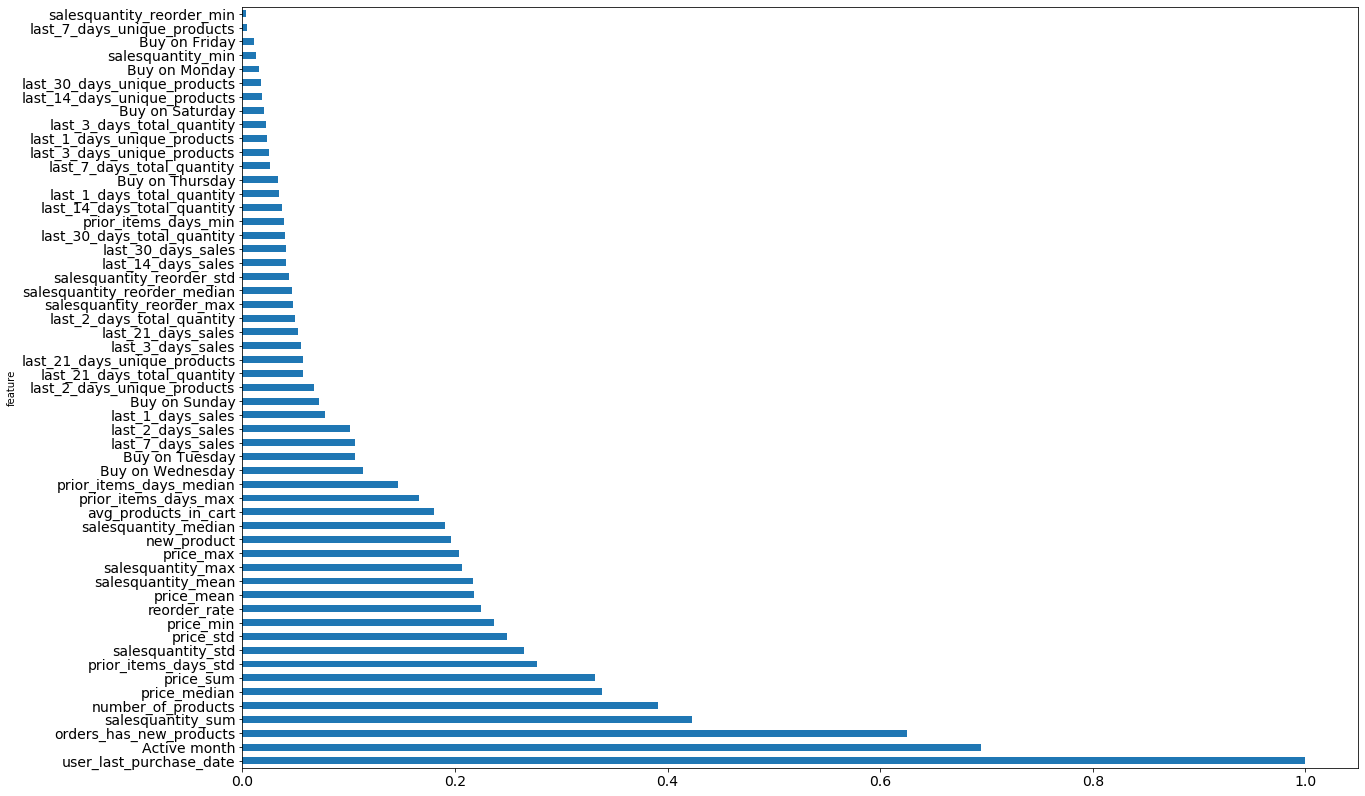

In [379]:
df_important["coff_norm"]\
    .rename({0: "Buy on Monday",
             1: "Buy on Tuesday",
             2: "Buy on Wednesday",
             3: "Buy on Thursday",
             4: "Buy on Friday",
             5: "Buy on Saturday",
             6: "Buy on Sunday",
             "month": "Active month"
            }).sort_values(ascending=False).plot(kind="barh",figsize=(20,14),fontsize=14)